In [47]:
# CREA LOS PLANOS DE MADURACION PARA COSECHA

In [2]:
# IMPORTACIONES
import sys
sys.path.append('..')
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

import os
import geopandas as gpd
import pandas as pd
import re
from collections import namedtuple
import unicodedata
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.patches import Patch
from docx.shared import Mm

import docxtpl
from docxtpl import DocxTemplate

In [3]:
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

#path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB

In [4]:
def generar_plano_os(shp_prop, path_tif, path_out):
    colores_orden = {
        0: '#DDDDDD', # Sin datos
        1: '#FF0000',  # Rojo
        2: '#FF4500',  # Naranja fuerte
        3: '#FFA500',  # Naranja
        4: '#FFB733',  # Naranja claro
        5: '#FFD700',  # Amarillo fuerte
        6: '#FFFF00',  # Amarillo
        7: '#CCFF00',  # Verde lima claro
        8: '#99CC00',  # Verde lima medio
        9: '#669900',  # Verde pasto
        10: '#336600', # Verde oliva oscuro
        11: '#006600', # Verde oscuro
    }
    leyenda_textos = {
        0: 'Sin datos',
        1: 'Lotes Maduros (iniciar cosecha)',
        2: '',
        3: '',
        4: '',
        5: '',
        6: 'Madurez intermedia',
        7: '',
        8: '',
        9: '',
        10: '',
        11: 'Lotes con maduracion baja'
    }
    shp_prop = shp_prop.copy()
    shp_prop['color'] = shp_prop['orden2'].map(colores_orden)
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='black', facecolor=shp_prop['color'], linewidth=1)
    
    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    
    # Leyenda dinámica para colores por orden
    legend_colores = [
        Patch(facecolor=colores_orden[orden], edgecolor='black', label=leyenda_textos[orden])
        for orden in colores_orden
    ]
    # Mostrar la leyenda
    ax.legend(handles=legend_colores, loc='upper right', fontsize=9,
              frameon=True, facecolor='white', edgecolor='black')
    out = os.path.join(path_out, str(shp_prop["unidad_02"].iloc[0]) + '.jpg')
    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [5]:
# Ruta completa al archivo .shp (cambia el nombre del archivo por el que necesitas)
ruta_shp =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\MADURACION\SHP\LOTES_MADURACION_2.shp"
# Cargar shapefile
gdf_cat = gpd.read_file(ruta_shp)
gdf_cat = gdf_cat[['unidad_01', 'unidad_02','unidad_03', 'unidad_04', 'unidad_05', 'area', 'orden2', 'geometry']]

In [6]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')
df_grupos.head(3)

,CODIGO CAÑERO,NOMBRE CAÑERO,GRUPO DE COSECHA,INSTITUCION,DELEGADO,obs,ver
0,742,ACSAMA ELVIRA AMURRIO DE,356,131.0,NaN,742.0,131.0
1,42034,ACSAMA MAMANI TEODORA,482,63.0,NaN,42034.0,63.0
2,465,ACSAMA SALVADOR MARIO REYES,356,131.0,NaN,465.0,131.0


In [7]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')

#Limpiar nombres de columnas
def limpiar_nombre(col):
    col = col.strip().lower()
    col = unicodedata.normalize('NFKD', col).encode('ascii', 'ignore').decode('utf-8')  # elimina tildes y ñ
    col = re.sub(r'\W+', '_', col)  # reemplaza cualquier no-alfanumérico por _
    return col

df_grupos.columns = [limpiar_nombre(col) for col in df_grupos.columns]

In [8]:
df_grupos

,codigo_canero,nombre_canero,grupo_de_cosecha,institucion,delegado,obs,ver
0,742,ACSAMA ELVIRA AMURRIO DE,356,131.0,NaN,742.0,131.0
1,42034,ACSAMA MAMANI TEODORA,482,63.0,NaN,42034.0,63.0
2,465,ACSAMA SALVADOR MARIO REYES,356,131.0,NaN,465.0,131.0
3,17,ACSAMA SEGOVIA SABINO,356,131.0,DELEGADO,17.0,131.0
4,18,ACUNA ARISPE HONORATO,354,126.0,NaN,18.0,126.0
...,...,...,...,...,...,...,...
1412,41548,ZAPATA CKOLO ALEXANDER,278,68.0,NaN,41548.0,68.0
1413,42017,ZAPATA CKOLO YOSELIN,278,68.0,NaN,42017.0,68.0
1414,16213,ZAPATA SERON SIMON,278,68.0,DELEGADO,16213.0,68.0
1415,13132,ZUMARAN MENACHO JORGE,409,50.0,DELEGADO,13132.0,50.0


In [36]:
cod_grupo= 247

grupo = df_grupos[df_grupos['grupo_de_cosecha'] == cod_grupo]

# Convertir cada fila a namedtuple usando .to_dict()
grupo_obj = []
for _, row in grupo.iterrows():
    fila_dict = row.to_dict()
    Tupla = namedtuple("grupo", fila_dict.keys())
    objeto = Tupla(*fila_dict.values())
    grupo_obj.append(objeto)

cods_ca = list(set(grupo['codigo_canero']))

df_filtrado = gdf_cat[gdf_cat['unidad_03'].isin(cods_ca)]
cods_prop = list(set(df_filtrado['unidad_01']))
props = [int(i) for i in cods_prop]
props

[867, 261, 263, 11, 1041, 831]

In [37]:
grupo

,codigo_canero,nombre_canero,grupo_de_cosecha,institucion,delegado,obs,ver
246,41834,CALVI PADILLA JUDITH,247,66.0,NaN,41834.0,66.0
747,41894,LEON CALVI HELBERT JAMIL,247,66.0,NaN,41894.0,66.0
753,7754,LEON MONDAQUE ROLY,247,66.0,DELEGADO,7754.0,66.0


G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\867_SAN JORGE--LEON ROLY.jpg
867
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\261_BELLA FLOR--LEON.jpg
261
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\263_EL TRIANGULO--LEON.jpg
263
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\11_EL CARMENCITO--LEON ROLY.jpg
11
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\1041_TIGRE II--LEON ROLY.jpg
1041
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\831_RANCHO CHICO--CALVI MARIO.jpg
831


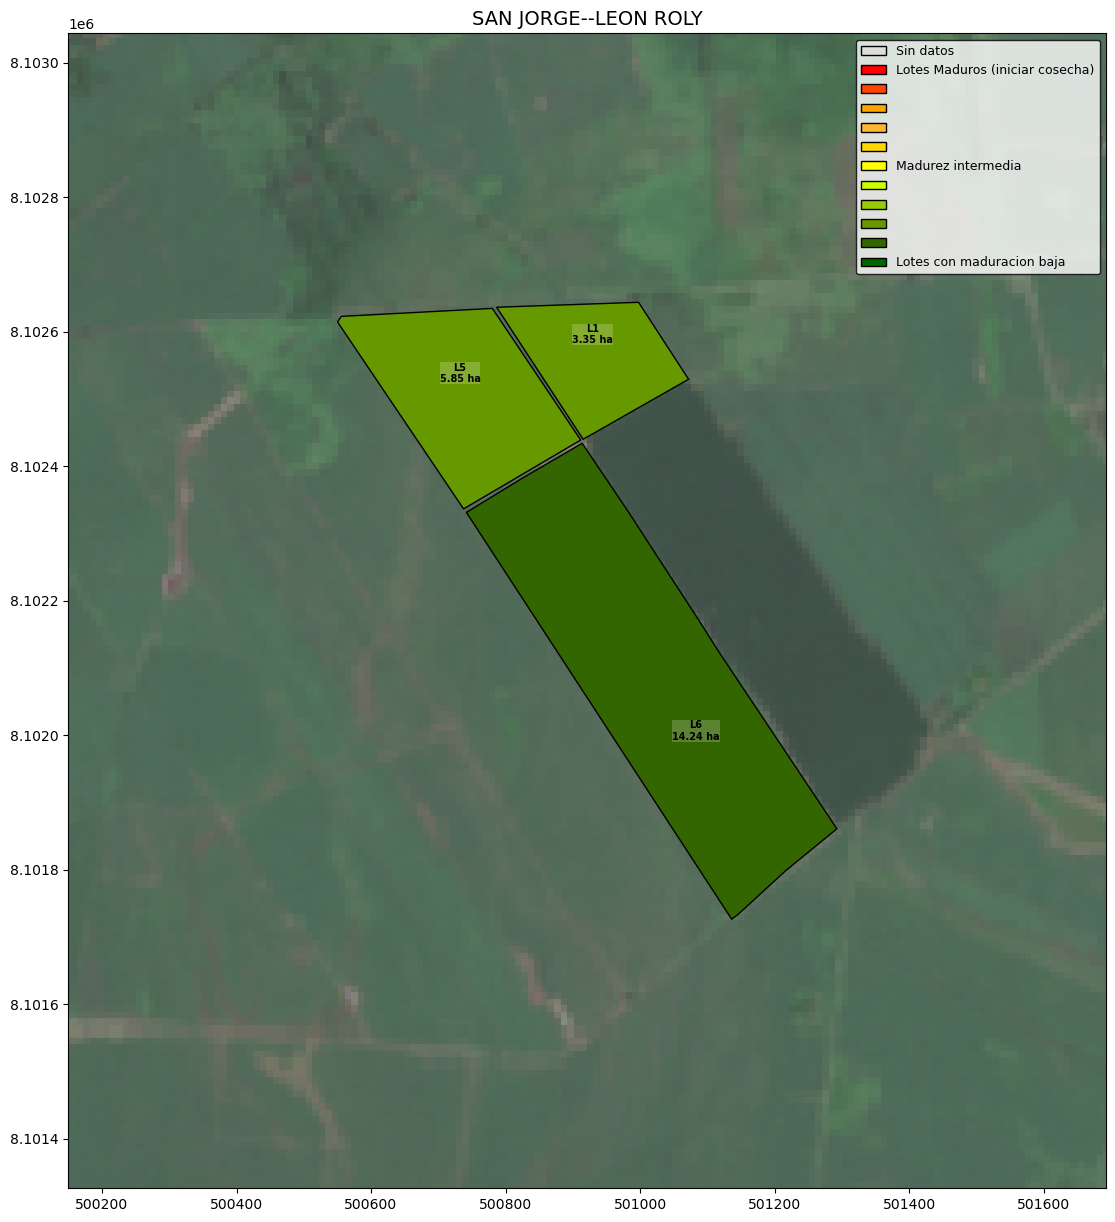

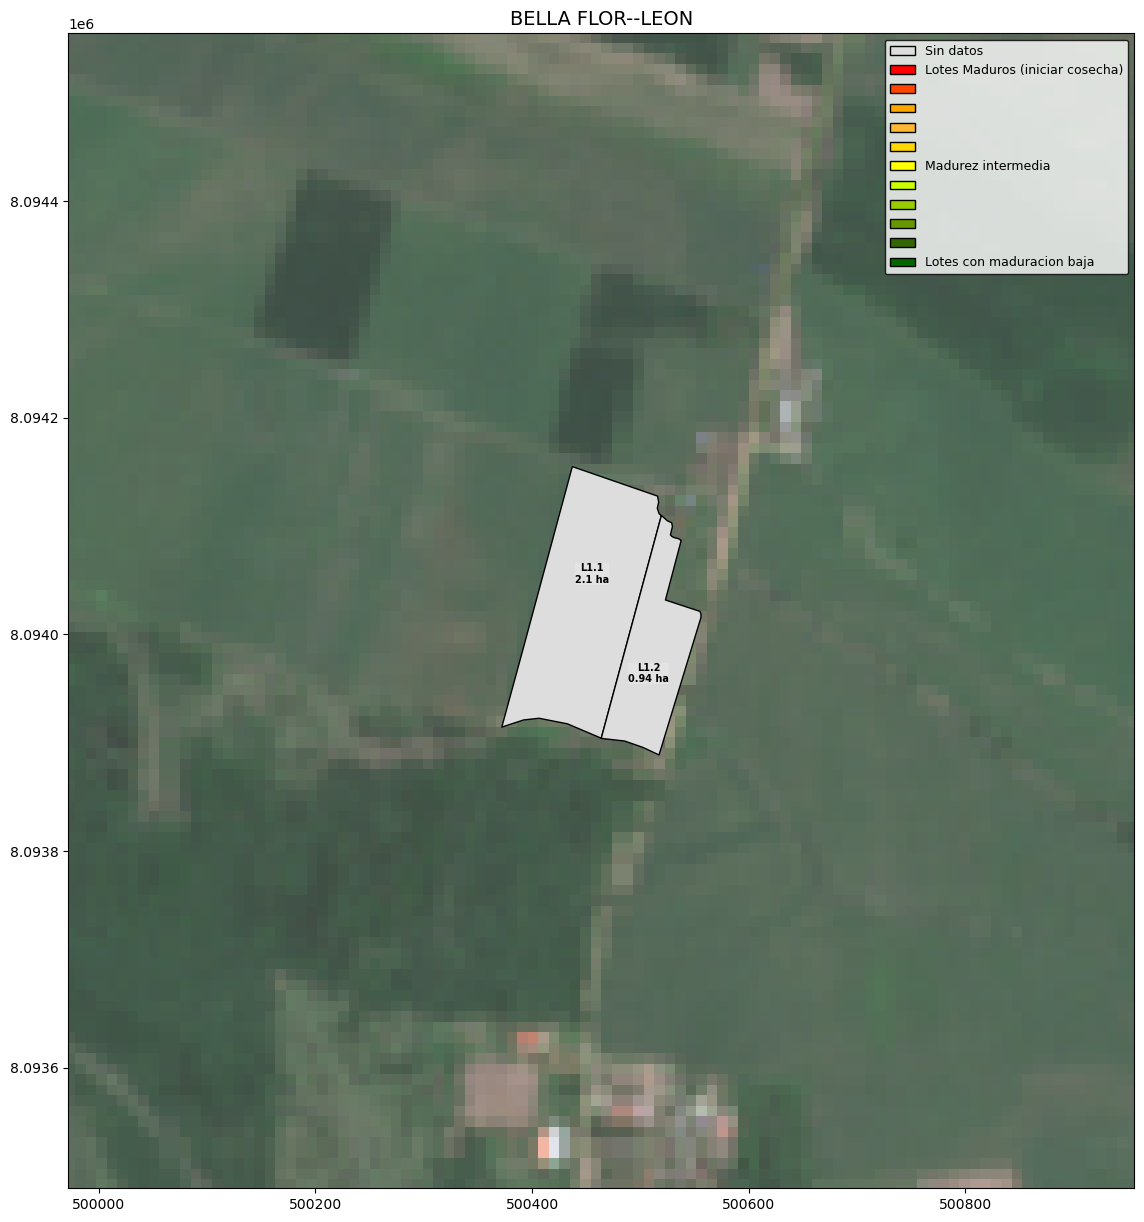

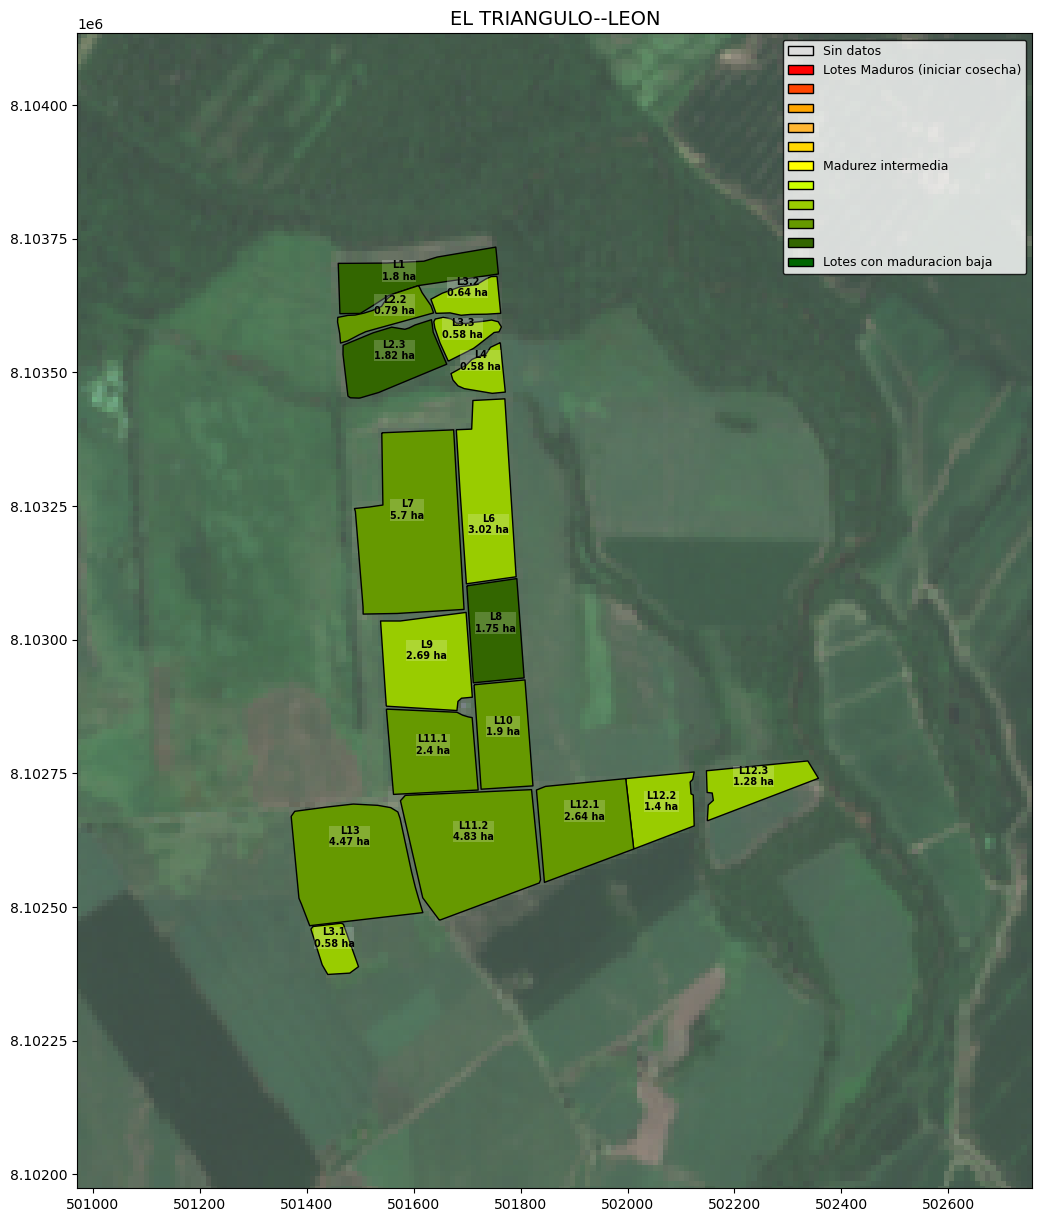

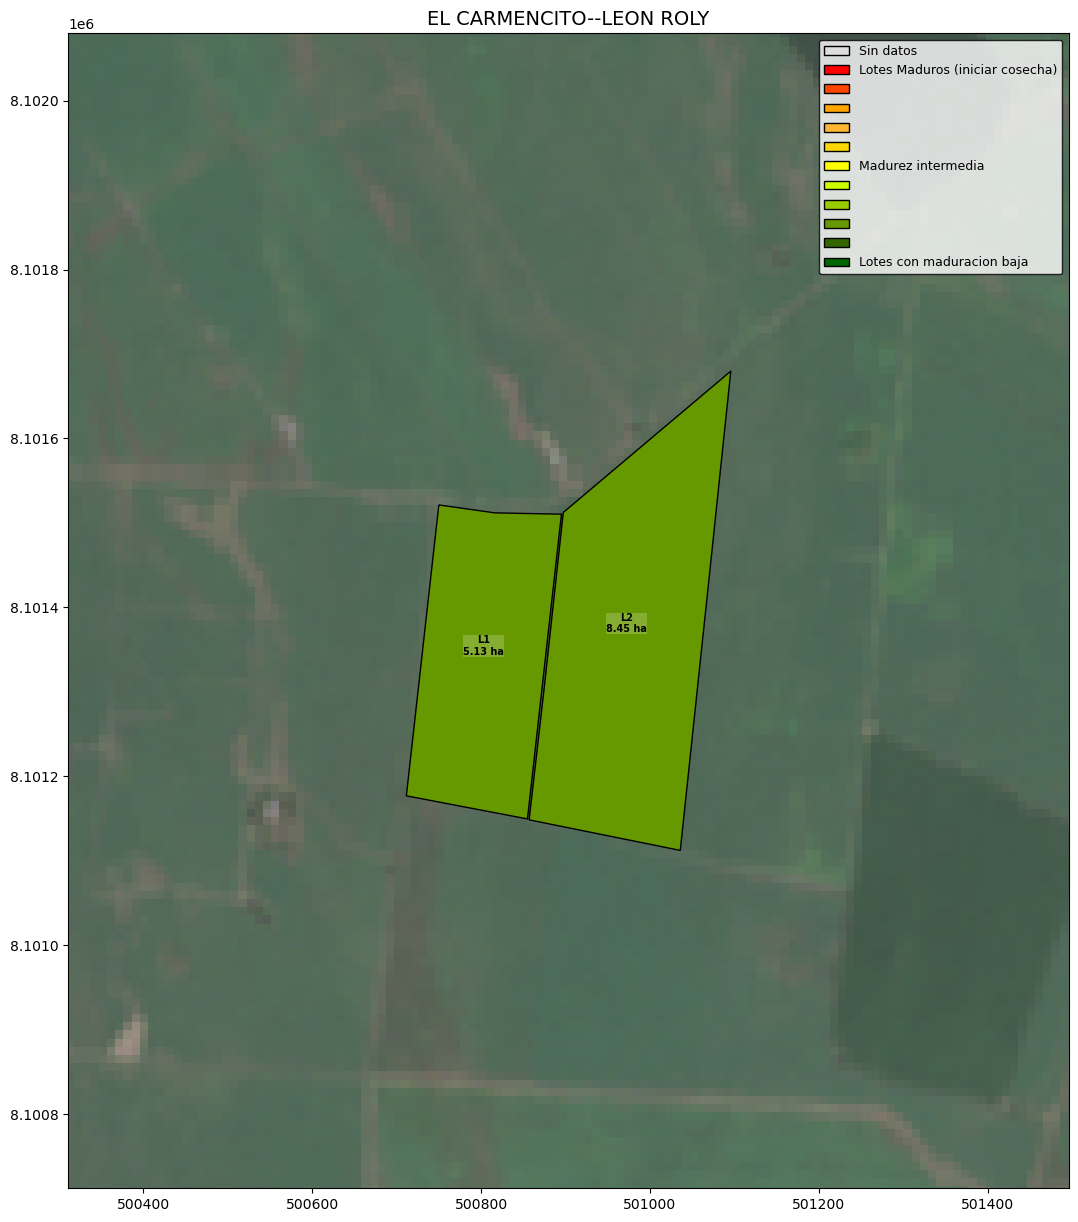

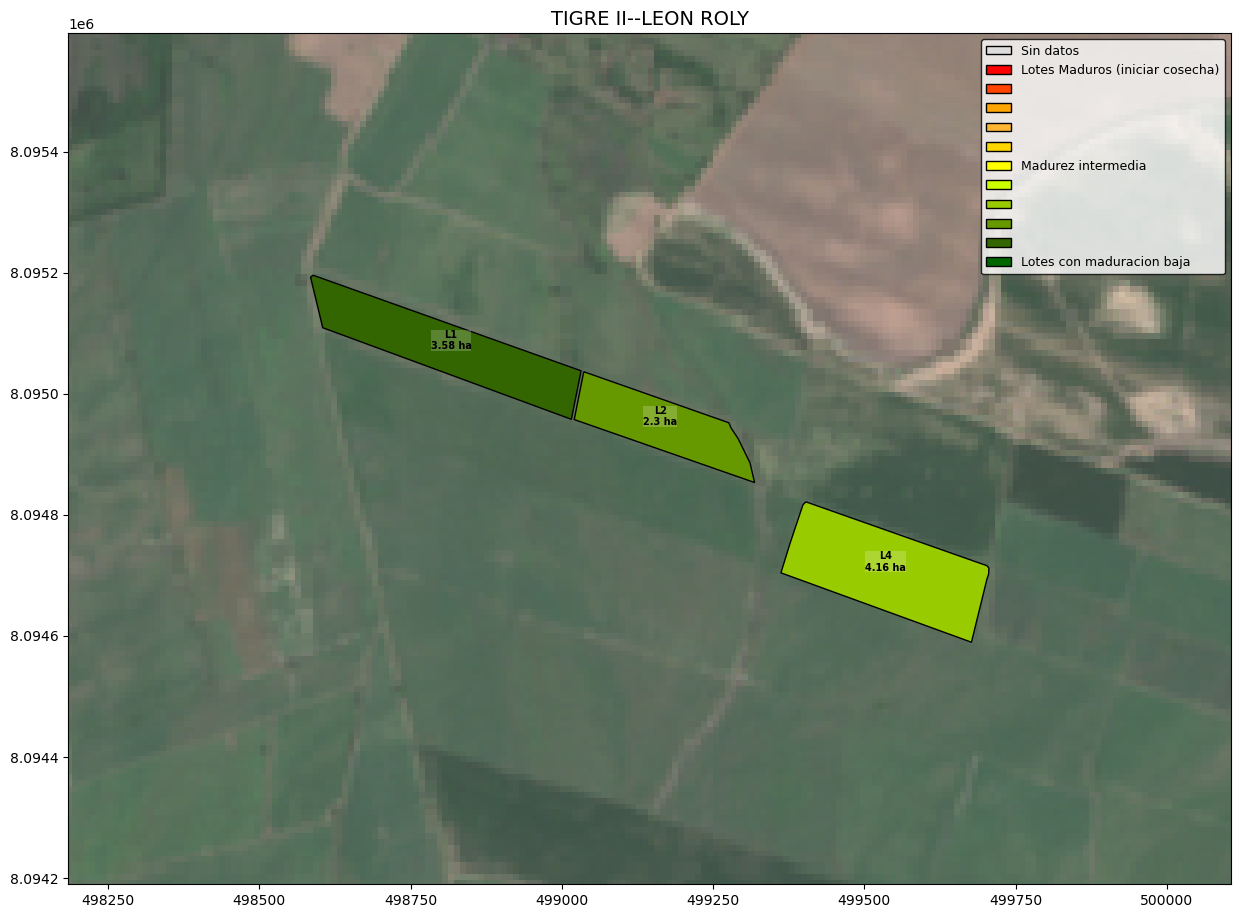

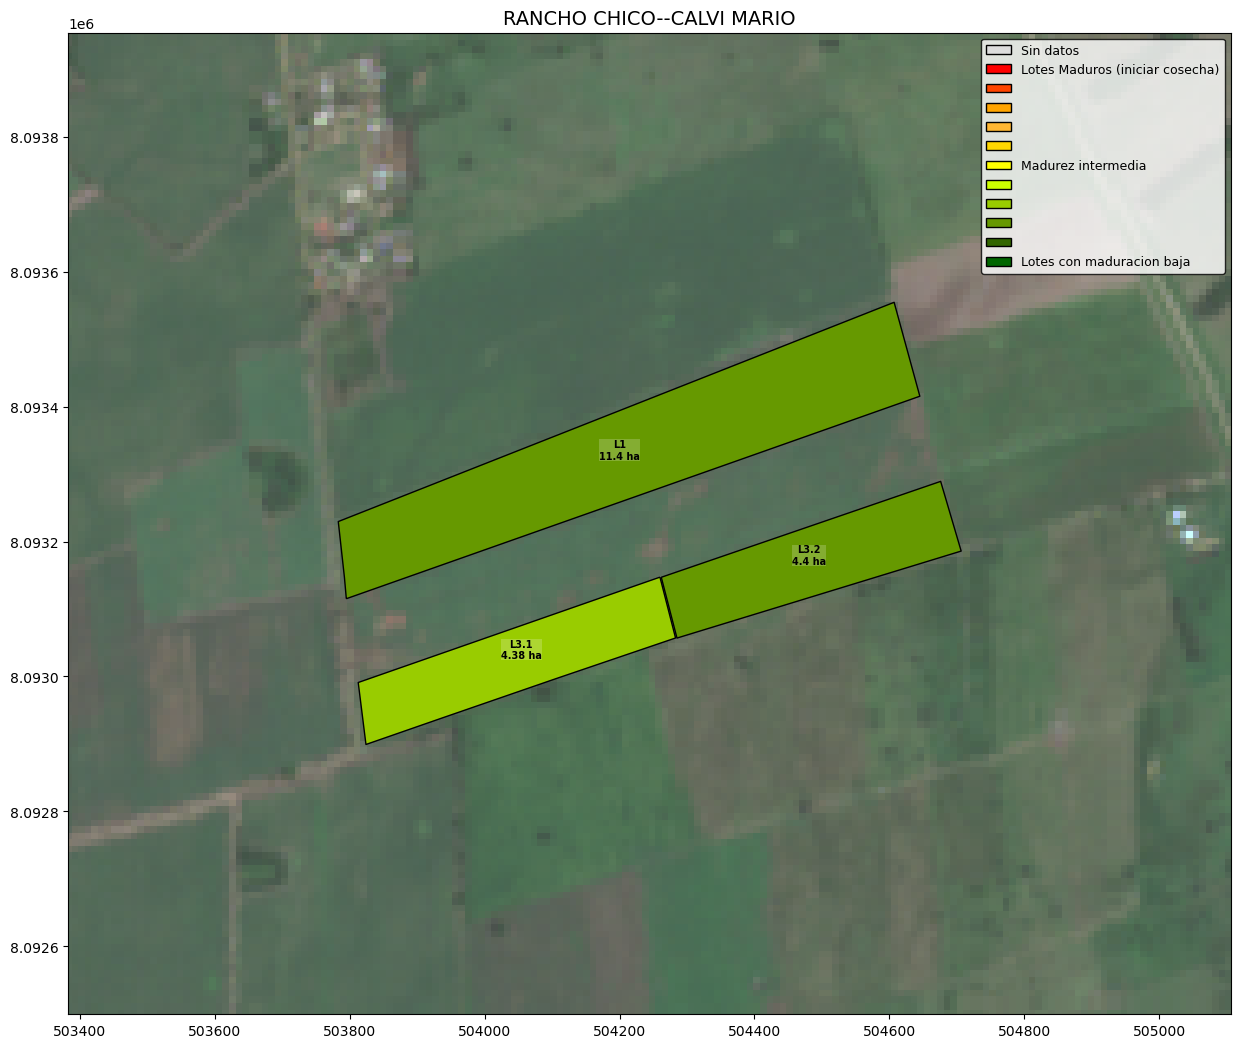

In [38]:
rutas_planos = []
for i in props:
    prop = gdf_cat[gdf_cat['unidad_01'] == i]
    prop = prop.copy()
    # Obtener los valores de unidad_01 y unidad_02
    prop['unidad_01'] = prop['unidad_01'].astype(int)
    unidad_01 = prop['unidad_01'].iloc[0]
    unidad_02 = prop['unidad_02'].iloc[0]
    # Crear el nombre del archivo concatenando unidad_01 y unidad_02
    nombre_archivo = f'{unidad_01}_{unidad_02}'
    path_plano = os.path.join(RUTA_COMPLETA, "planos", nombre_archivo + '.jpg')
    print(path_plano)
    generar_plano_os(prop, path_tif, path_plano)
    rutas_planos.append(path_plano)
    print(i)

In [39]:
doc = DocxTemplate(RUTA_COMPLETA + "/templates/tpl_rpt_maduracion.docx")
lista_InlineImage = []
for plano in rutas_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

context = {'grupo':grupo_obj, 'planos':lista_InlineImage}
doc.render(context)
file_name = f"_{grupo_obj[0].grupo_de_cosecha}" 
doc.save(RUTA_COMPLETA + '/informes/' + file_name + '.docx')